# Stock Index

We will predicting the stock price of the S&P 500 using historic prices from 2007 to 2018

The Data Consist of 4 stock indices:
>
*(S&P500)[https://en.wikipedia.org/wiki/S%26P_500_Index]

*(JPX400)[https://www.jpx.co.jp/english/markets/indices/jpx-nikkei400]

*(SSEC)[https://en.wikipedia.org/wiki/SSE_Composite_Index]

*(KOSPI)[https://en.wikipedia.org/wiki/KOSPI]


This source of the data is from kaggle.com(https://www.kaggle.com/pyioneer/stock-index)
    

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

In [2]:
df = pd.read_csv("stock_exchange_index.csv")
df.head()

,DATE,S&P500,JPX400,SSEC,KOSPI
0,2007-01-01,NaN,NaN,NaN,1434.46
1,2007-01-02,NaN,NaN,NaN,1435.26
2,2007-01-03,1416.60,NaN,NaN,1409.35
3,2007-01-04,1418.34,14545.50,2715.72,1397.29
4,2007-01-05,1409.71,14326.44,2641.33,1385.76


In [3]:
df["DATE"] = pd.to_datetime(df.DATE)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4383 entries, 0 to 4382
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    4383 non-null   datetime64[ns]
 1   S&P500  3020 non-null   float64       
 2   JPX400  2941 non-null   float64       
 3   SSEC    2920 non-null   float64       
 4   KOSPI   4383 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 171.3 KB


## Exploratory Data Analysis

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4383 entries, 0 to 4382
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    4383 non-null   datetime64[ns]
 1   S&P500  3020 non-null   float64       
 2   JPX400  2941 non-null   float64       
 3   SSEC    2920 non-null   float64       
 4   KOSPI   4383 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 171.3 KB


In [6]:
df.describe()

,S&P500,JPX400,SSEC,KOSPI
count,3020.000000,2941.000000,2920.000000,4383.000000
mean,1696.062722,11042.823968,2925.573325,1911.190801
std,544.576517,3058.797292,759.552464,296.553993
min,676.530000,6014.220000,1706.700000,938.750000
25%,1281.907500,7839.700000,2331.805000,1770.980000
50%,1525.410000,11306.620000,2863.390000,1957.500000
75%,2087.842500,13926.950000,3235.315000,2043.690000
max,2930.750000,16937.630000,6092.060000,2598.190000


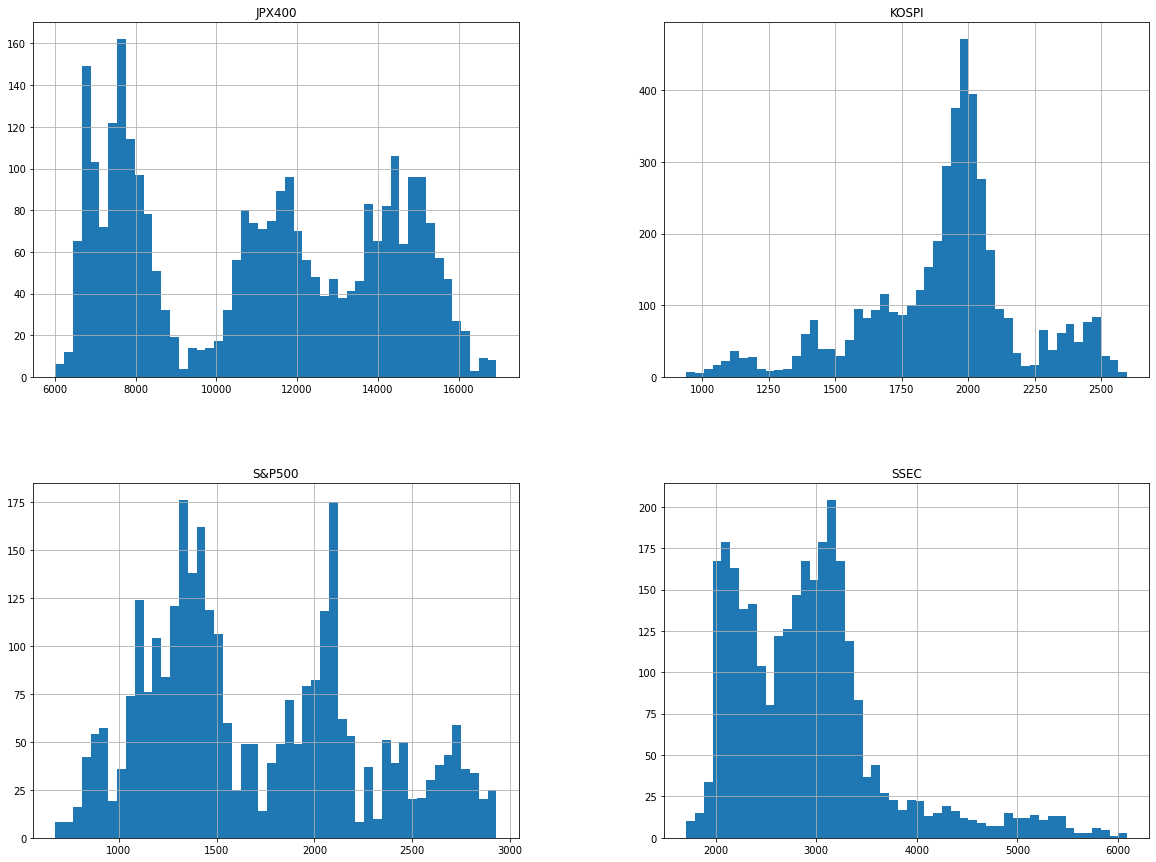

In [7]:
%matplotlib inline
df.hist(bins=50, figsize=(20, 15))
plt.savefig("stock_hist.png")

In [8]:
df.dropna(subset=["S&P500"], inplace=True)
df.fillna(method="ffill", inplace=True)
df.reset_index(drop=True, inplace=True)
df.drop(df.index[[0]], inplace=True)
df.head()

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3019 entries, 1 to 3019
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATE    3019 non-null   datetime64[ns]
 1   S&P500  3019 non-null   float64       
 2   JPX400  3019 non-null   float64       
 3   SSEC    3019 non-null   float64       
 4   KOSPI   3019 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 141.5 KB


In [9]:
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

train_set, test_set = split_train_test(df, 0.2)

In [10]:
train_set.shape, test_set.shape

((2416, 5), (603, 5))

In [11]:
from zlib import crc32

#check the test set to ensure it remains constant even if data is refreshed
def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32


def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [12]:
df_with_id = df.reset_index()
train_set, test_set = split_train_test_by_id(df_with_id, 0.2, "index")

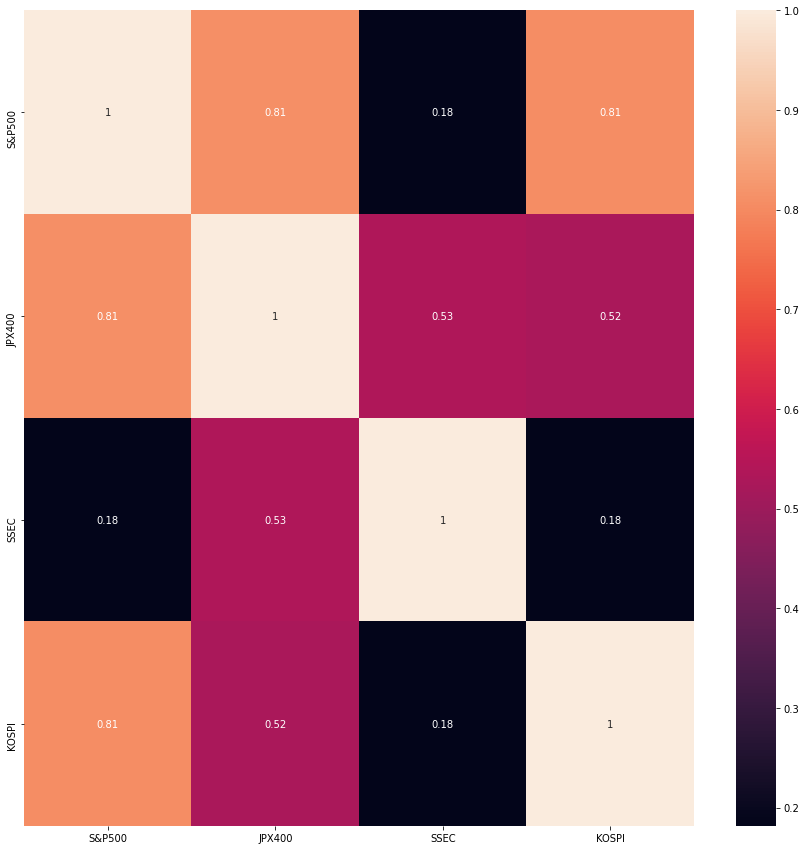

In [13]:
corr = df.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True);

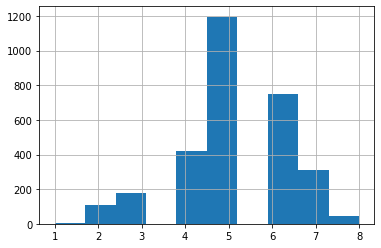

In [14]:
df["KOSPI_strat"] = pd.cut(df["KOSPI"], 
                     bins=[0, 1000, 1250, 1500, 1750, 2000, 2250, 2500, np.inf],
                     labels=[1, 2, 3, 4, 5, 6, 7, 8])

df["KOSPI_strat"].hist();

In [16]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(df, df["KOSPI_strat"]):
    strat_train_set = df.iloc[train_index]
    strat_test_set = df.iloc[test_index]

In [17]:
strat_test_set["KOSPI_strat"].value_counts()/ len(strat_test_set)

5    0.395695
6    0.248344
4    0.139073
7    0.104305
3    0.059603
2    0.036424
8    0.014901
1    0.001656
Name: KOSPI_strat, dtype: float64

In [18]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("KOSPI_strat", axis=1, inplace=True)

/Users/jacobywilkerson/.local/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [19]:

# df = df[df['S&P500'].notna()]
# df.fillna(method="ffill", inplace=True)
# df.reset_index(drop=True, inplace=True)
# df.drop(df.index[[0]], inplace=True)
# df.head()



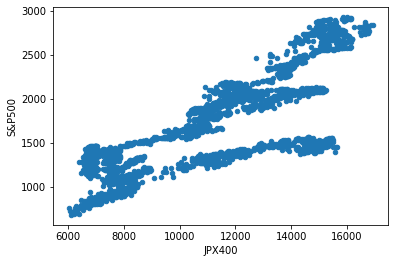

In [20]:
df.plot(kind="scatter", x="JPX400", y="S&P500");

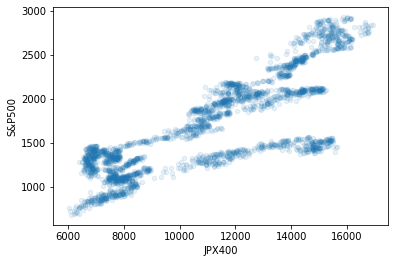

In [21]:
df.plot(kind="scatter", x="JPX400", y="S&P500", alpha=0.1);

In [22]:
corr_matrix = df.corr()
corr_matrix["S&P500"].sort_values(ascending=False)

S&P500    1.000000
JPX400    0.810583
KOSPI     0.807993
SSEC      0.181670
Name: S&P500, dtype: float64

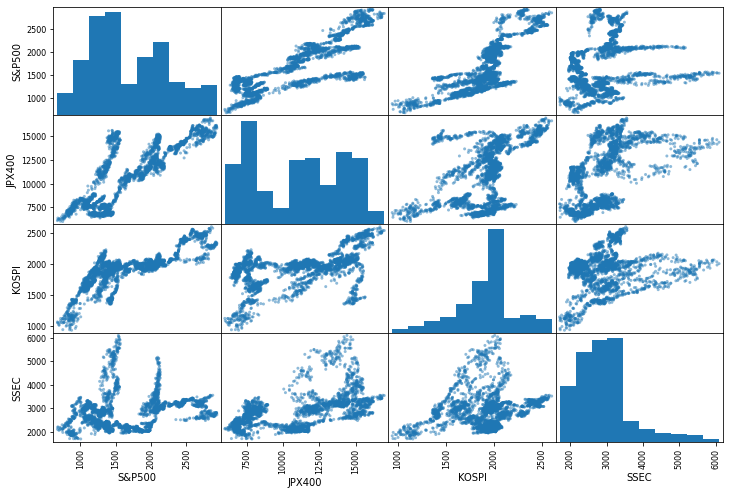

In [23]:
from pandas.plotting import scatter_matrix


attributes=["S&P500", "JPX400", "KOSPI", "SSEC"]

scatter_matrix(df[attributes], figsize=(12, 8));
plt.savefig("scatter_matrix.png")

## Prepare Data For Machine Learning

In [24]:
df_train = strat_train_set.drop("S&P500", axis=1)
df_train_labels = strat_train_set["S&P500"].copy()

In [25]:
from sklearn.preprocessing import StandardScaler

df_num = df_train.drop("DATE", axis=1)

scaler = StandardScaler()
df_num_scaler = scaler.fit_transform(df_num)

In [27]:
from sklearn.compose import ColumnTransformer

num_attribs = list(df_num)

full_pipeline = ColumnTransformer([
    ("num", StandardScaler(), num_attribs)
])


df_train_prepared = full_pipeline.fit_transform(df_train)

## Select and Train Model

In [29]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()

linreg.fit(df_train_prepared, df_train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [30]:
some_data = df_train.iloc[:5]
some_data_labels = df_train_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", linreg.predict(some_data_prepared))

Predictions: [1353.74407172 1937.89659309 1796.36870747 1257.53856937  787.66621406]


In [31]:
print("Actual Labels:", list(some_data_labels))

Actual Labels: [1402.8, 1890.9, 1455.54, 1213.4, 869.6]


In [35]:
from sklearn.metrics import mean_squared_error

sp500_predictions = linreg.predict(df_train_prepared)
lin_mse = mean_squared_error(df_train_labels, sp500_predictions)
lin_rmse = np.sqrt(lin_mse)

lin_rmse

157.37074104471168

In [36]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(df_train_prepared, df_train_labels)

sp500_predictions = tree_reg.predict(df_train_prepared)
tree_mse = mean_squared_error(df_train_labels, sp500_predictions)
tree_rmse = np.sqrt(tree_mse)

tree_rmse



0.9238080115673531

In [37]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, df_train_prepared, df_train_labels,
                         scoring="neg_mean_squared_error", cv=10)

tree_rmse_scores = np.sqrt(-scores)

In [38]:
def display_scores(scores):
    
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std())
    
display_scores(tree_rmse_scores)

Scores: [53.17037392 46.86084424 73.26535272 55.61435756 57.73026066 60.4784679
 72.74657253 38.56962208 59.53290689 55.47571261]
Mean: 57.34444711161409
Standard Deviation: 9.958761204262379


In [40]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(df_train_prepared, df_train_labels)

sp500_predictions = forest_reg.predict(df_train_prepared)
forest_mse = mean_squared_error(df_train_labels, sp500_predictions)
forest_rmse = np.sqrt(forest_mse)

forest_rmse

16.21777972757668

In [41]:
forest_scores = cross_val_score(forest_reg, df_train_prepared, df_train_labels,
                                scoring="neg_mean_squared_error", cv=10)

forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)

Scores: [38.07922186 40.56504238 49.9405161  43.19767812 46.0569852  49.5376001
 46.30546045 30.88691004 45.08402182 47.65380637]
Mean: 43.730724244069236
Standard Deviation: 5.556552787186738


In [53]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'n_estimators':[50 , 70  , 90], 'max_features':[0.1 , 0.15, 0.20, 0.25]},
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [0.1, 0.2, 0.3, 0.4]}
]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring="neg_mean_squared_error",
                           return_train_score=True)

grid_search.fit(df_train_prepared, df_train_labels)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [54]:
grid_search.best_params_

{'max_features': 0.2, 'n_estimators': 90}

In [55]:
grid_search.best_estimator_

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.2, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=90, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [57]:
cv_res = grid_search.cv_results_

In [60]:
for mean_score, params in zip(cv_res["mean_test_score"], cv_res["params"]):
    print(np.sqrt(-mean_score), params)

49.42490596833172 {'max_features': 0.1, 'n_estimators': 50}
49.64432688420903 {'max_features': 0.1, 'n_estimators': 70}
47.90349921456868 {'max_features': 0.1, 'n_estimators': 90}
48.5390060426873 {'max_features': 0.15, 'n_estimators': 50}
49.14851126453382 {'max_features': 0.15, 'n_estimators': 70}
48.18721520410187 {'max_features': 0.15, 'n_estimators': 90}
48.57562035057752 {'max_features': 0.2, 'n_estimators': 50}
48.43940953920657 {'max_features': 0.2, 'n_estimators': 70}
47.68537966907242 {'max_features': 0.2, 'n_estimators': 90}
49.208102799917285 {'max_features': 0.25, 'n_estimators': 50}
48.052426538447094 {'max_features': 0.25, 'n_estimators': 70}
49.293902204085306 {'max_features': 0.25, 'n_estimators': 90}
66.72646696955943 {'bootstrap': False, 'max_features': 0.1, 'n_estimators': 3}
52.19059765385291 {'bootstrap': False, 'max_features': 0.1, 'n_estimators': 10}
65.01657453664373 {'bootstrap': False, 'max_features': 0.2, 'n_estimators': 3}
52.90627206052744 {'bootstrap': Fa

In [62]:
feature_importances = grid_search.best_estimator_.feature_importances_

In [64]:
sorted(zip(feature_importances, num_attribs), reverse=True)

[(0.4490926418731743, 'KOSPI'),
 (0.40515665715748556, 'JPX400'),
 (0.14575070096934004, 'SSEC')]

In [65]:
## Evaluate System on Test Set

In [66]:
final_model = grid_search.best_estimator_

X_test = strat_test_set.drop("S&P500", axis=1)
y_test = strat_test_set["S&P500"].copy()


X_test_prepared = full_pipeline.transform(X_test)

In [67]:
final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

final_rmse

52.218235097325405

### Compute 95%confidence interval

In [69]:
from scipy import stats

confidence = 0.95
squared_errors = (final_predictions - y_test)**2
np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                         loc=squared_errors.mean(),
                         scale=stats.sem(squared_errors)))


array([41.03019609, 61.40041663])

### Save Model

In [70]:
import joblib

joblib.dump(final_model, "final_model.pkl")

['final_model.pkl']

## Extra Material

In [77]:
# A full pipeline with preparation and predictions
from sklearn.pipeline import Pipeline


full_pipeline_with_predictor = Pipeline([
    ("preparation", full_pipeline),
    ("forest_reg", RandomForestRegressor())
    ])

full_pipeline_with_predictor.fit(df_train, df_train_labels)
full_pipeline_with_predictor.predict(some_data)

array([1402.4211, 1896.9961, 1453.3469, 1218.6232,  863.7263])

In [79]:
# Try a support vector machine regressor with various parameters

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR

param_grid = [
    {'kernel': ["linear"], 'C': [10., 30., 100., 300., 1000., 3000., 10000., 30000.0]},
    {'kernel': ["rbf"], 'C': [1.0, 3.0, 10., 30., 100., 300., 1000.0],
     'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}
]

svm_reg = SVR()
grid_search = GridSearchCV(svm_reg, param_grid, cv=5, scoring="neg_mean_squared_error",
                           verbose=2)

grid_search.fit(df_train_prepared, df_train_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   0.1s
[CV] C=10.0, kernel=linear ...........................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] ............................ C=10.0, kernel=linear, total=   0.1s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   0.1s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   0.1s
[CV] C=10.0, kernel=linear ...........................................
[CV] ............................ C=10.0, kernel=linear, total=   0.1s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   0.1s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   0.1s
[CV] C=30.0, kernel=linear ...........................................
[CV] ............................ C=30.0, kernel=linear, total=   0.1s
[CV] C=30.0, kernel=linear ...........................................
[CV] .

[CV] ..................... C=1.0, gamma=0.3, kernel=rbf, total=   0.1s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=   0.1s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=   0.1s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=   0.1s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=   0.1s
[CV] C=1.0, gamma=1.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=1.0, kernel=rbf, total=   0.1s
[CV] C=1.0, gamma=3.0, kernel=rbf ....................................
[CV] ..................... C=1.0, gamma=3.0, kernel=rbf, total=   0.1s
[CV] C=1.0, gamma=3.0, kernel=rbf ....................................
[CV] .

[CV] .................... C=10.0, gamma=0.3, kernel=rbf, total=   0.2s
[CV] C=10.0, gamma=0.3, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=0.3, kernel=rbf, total=   0.2s
[CV] C=10.0, gamma=0.3, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=0.3, kernel=rbf, total=   0.2s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=1.0, kernel=rbf, total=   0.2s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=1.0, kernel=rbf, total=   0.2s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=1.0, kernel=rbf, total=   0.2s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .................... C=10.0, gamma=1.0, kernel=rbf, total=   0.1s
[CV] C=10.0, gamma=1.0, kernel=rbf ...................................
[CV] .

[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=   0.2s
[CV] C=100.0, gamma=0.3, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=   0.2s
[CV] C=100.0, gamma=0.3, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=   0.2s
[CV] C=100.0, gamma=0.3, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=   0.2s
[CV] C=100.0, gamma=0.3, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=0.3, kernel=rbf, total=   0.2s
[CV] C=100.0, gamma=1.0, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=1.0, kernel=rbf, total=   0.2s
[CV] C=100.0, gamma=1.0, kernel=rbf ..................................
[CV] ................... C=100.0, gamma=1.0, kernel=rbf, total=   0.2s
[CV] C=100.0, gamma=1.0, kernel=rbf ..................................
[CV] .

[CV] .................. C=1000.0, gamma=0.1, kernel=rbf, total=   0.2s
[CV] C=1000.0, gamma=0.1, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=0.1, kernel=rbf, total=   0.2s
[CV] C=1000.0, gamma=0.3, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=0.3, kernel=rbf, total=   0.2s
[CV] C=1000.0, gamma=0.3, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=0.3, kernel=rbf, total=   0.2s
[CV] C=1000.0, gamma=0.3, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=0.3, kernel=rbf, total=   0.2s
[CV] C=1000.0, gamma=0.3, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=0.3, kernel=rbf, total=   0.2s
[CV] C=1000.0, gamma=0.3, kernel=rbf .................................
[CV] .................. C=1000.0, gamma=0.3, kernel=rbf, total=   0.2s
[CV] C=1000.0, gamma=1.0, kernel=rbf .................................
[CV] .

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:  1.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid=[{'C': [10.0, 30.0, 100.0, 300.0, 1000.0, 3000.0,
                                10000.0, 30000.0],
                          'kernel': ['linear']},
                         {'C': [1.0, 3.0, 10.0, 30.0, 100.0, 300.0, 1000.0],
                          'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0],
                          'kernel': ['rbf']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_mean_squared_error', verbose=2)

In [81]:
negative_mse = grid_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

44.9644450287513

In [82]:
grid_search.best_params_

{'C': 1000.0, 'gamma': 3.0, 'kernel': 'rbf'}

In [88]:
# Try replacing GridSearchCV with RandomizedSearchCV

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal

param_distribs = {
    'kernel': ['linear', 'rbf'],
    'C': reciprocal(20, 200000),
    'gamma': expon(scale=1.0)
}

svm_reg = SVR()
rnd_search = RandomizedSearchCV(svm_reg, param_distributions=param_distribs,
                                n_iter=50, cv=5, scoring="neg_mean_squared_error",
                                verbose=2, random_state=42)

rnd_search.fit(df_train_prepared, df_train_labels)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   0.4s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   0.3s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   0.4s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   0.3s
[CV] C=629.782329591372, gamma=3.010121430917521, kernel=linear ......
[CV]  C=629.782329591372, gamma=3.010121430917521, kernel=linear, total=   0.4s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=   3.5s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=   4.1s
[CV] C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf ......
[CV]  C=26290.206464300216, gamma=0.9084469696321253, kernel=rbf, total=   6.7s
[CV] C=26290.2

[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  24.1s
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  23.4s
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  32.4s
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  29.5s
[CV] C=171377.39570378003, gamma=0.628789100540856, kernel=linear ....
[CV]  C=171377.39570378003, gamma=0.628789100540856, kernel=linear, total=  24.9s
[CV] C=5385.293820172355, gamma=0.18696125197741642, kernel=linear ...
[CV]  C=5385.293820172355, gamma=0.18696125197741642, kernel=linear, total=   1.4s
[CV] C=5385.293820172355, gamma=0.18696125197741642, kernel=linear ...
[CV]  C=5385.293820172355, gamma=0.18696125197741642, kernel=linear, total=   1.2

[CV]  C=761.4316758498783, gamma=2.6126336514161914, kernel=linear, total=   0.4s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  13.4s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  14.8s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  14.3s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  15.6s
[CV] C=97392.81883041795, gamma=0.09265545895311562, kernel=linear ...
[CV]  C=97392.81883041795, gamma=0.09265545895311562, kernel=linear, total=  14.6s
[CV] C=2423.0759984939164, gamma=3.248614270240346, kernel=linear ....
[CV]  C=2423.0759984939164, gamma=3.248614270240346, kernel=linear, total=   

[CV]  C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf, total=   7.8s
[CV] C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf .......
[CV]  C=56681.80859029545, gamma=0.9763011917123741, kernel=rbf, total=  10.0s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=   0.1s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=   0.1s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=   0.1s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=   0.1s
[CV] C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf .......
[CV]  C=48.15822390928914, gamma=0.4633351167983427, kernel=rbf, total=   0.1s
[CV] C=399.7268155705

[CV]  C=129.8000604143307, gamma=2.8621383676481322, kernel=linear, total=   0.2s
[CV] C=129.8000604143307, gamma=2.8621383676481322, kernel=linear ....
[CV]  C=129.8000604143307, gamma=2.8621383676481322, kernel=linear, total=   0.2s
[CV] C=129.8000604143307, gamma=2.8621383676481322, kernel=linear ....
[CV]  C=129.8000604143307, gamma=2.8621383676481322, kernel=linear, total=   0.2s
[CV] C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf ......
[CV]  C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf, total=   0.2s
[CV] C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf ......
[CV]  C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf, total=   0.2s
[CV] C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf ......
[CV]  C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf, total=   0.2s
[CV] C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf ......
[CV]  C=288.4269299593897, gamma=0.17580835850006285, kernel=rbf, total=   0.2s
[CV] C=2

[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed: 17.6min finished


RandomizedSearchCV(cv=5, error_score=nan,
                   estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                                 epsilon=0.1, gamma='scale', kernel='rbf',
                                 max_iter=-1, shrinking=True, tol=0.001,
                                 verbose=False),
                   iid='deprecated', n_iter=50, n_jobs=None,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11a03b760>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x11a988be0>,
                                        'kernel': ['linear', 'rbf']},
                   pre_dispatch='2*n_jobs', random_state=42, refit=True,
                   return_train_score=False, scoring='neg_mean_squared_error',
                   verbose=2)

In [89]:
negative_mse = rnd_search.best_score_
rmse = np.sqrt(-negative_mse)
rmse

42.55252730609708